## INFO

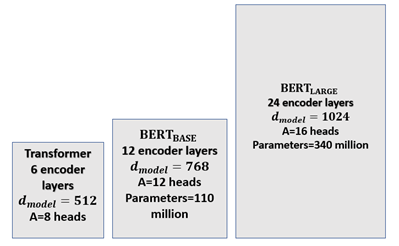

The model was trained with two tasks. The first method is Masked Language
Modeling (MLM). The second method is Next Sentence Prediction (NSP).

It is important to note that BERT applies WordPiece, a sub-word
segmentation method, tokenization to the inputs. It also uses
learned positional encoding, not the sine-cosine approach.



Two new tokens were added:

•[CLS] is a binary classification token added to the beginning of the first sequence to predict if the second sequence follows the first sequence.
A positive sample is usually a pair of consecutive sentences taken from
a dataset. A negative sample is created using sequences from different
documents.

•[SEP] is a separation token that signals the end of a sequence.


The input embedding and positional encoding sub-layer of a BERT model can be
summed up as follows:

•A sequence of words is broken down into WordPiece tokens.

•A [MASK] token will randomly replace the initial word tokens for masked language modeling training.

•A [CLS] classification token is inserted at the beginning of a sequence for classification purposes.

•A [SEP] token separates two sentences (segments, phrases) for NSP training.

•Sentence embedding is added to token embedding, so that sentence A has a different sentence embedding value than sentence B.

•Positional encoding is learned. The sine-cosine positional encoding method of the original Transformer is not applied.

Some additional key features are:

•BERT uses bidirectional attention in all of its multi-head attention sub-layers,
opening vast horizons of learning and understanding relationships between
tokens.

•BERT introduces scenarios of unsupervised embedding, pretraining models with unlabeled text. This forces the model to think harder during the multi-head attention learning process. This makes BERT able to learn how languages are built and apply this knowledge to downstream tasks without having to pretrain each time.

•BERT also uses supervised learning, covering all bases in the pretraining process.

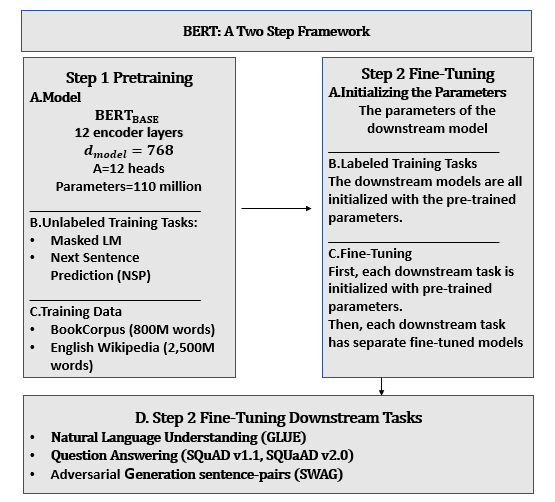

## Activating the GPU

In [1]:
import torch 
torch.cuda.is_available()

True

In [2]:
!pip install -q transformers

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup


2023-05-29 19:29:02.135441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 19:29:02.945065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nitiz/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tqdm import tqdm, trange

In [5]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

## Specifying CUDA as the device for torch

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

## Loading the dataset

In [7]:
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("cola_public/raw/in_domain_train.tsv" , delimiter = '\t', header = None,names = ['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [8]:
df.sample(10)

,sentence_source,label,label_notes,sentence
7055,sgww85,0,*,To go and buying whiskey is not the solution t...
4330,ks08,0,*,They promised it to rain.
2775,l-93,1,NaN,Steve tossed the ball at Anna.
7199,sks13,1,NaN,It was a first edition of Richard III that Ann...
7793,ad03,1,NaN,Cassandra has warned Agamemnon again.
2169,l-93,1,NaN,a The butcher cuts the meat.
2670,l-93,1,NaN,Nora sent the book to Peter.
5271,b_82,1,NaN,That he has blood on his hands proves that Joh...
2767,l-93,1,NaN,Michelle kept the papers under the desk.
8056,ad03,1,NaN,It hung on the wall.


## Creating sentences, label lists, and adding BERT tokens

In [9]:
sentences = df.sentence.values

sentences = ["[CLS]" + sentence + "[SEP]" for sentence in sentences]
labels = df.label.values

## Activating the BERT tokenizer

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenized first sentence:")
print (tokenized_texts[0])

Tokenized first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


### Processing the data

In [11]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen= MAX_LEN, dtype = 'long', truncating = 'post', padding = 'post')


## Creating attention masks

In [12]:
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

## Splitting data into training and validation sets

In [13]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state = 2018, test_size = 0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks,input_ids,random_state=2018, test_size=0.1)

## Converting all the data into torch tensors

In [14]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

## Selecting a batch size and creating an iterator

In [15]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)


## BERT model configuration

In [16]:
try:
    import transformers
    
except:
    !pip -qq install transformers
    
from transformers import BertModel, BertConfig
configuration = BertConfig()

model = BertModel(configuration)

configuration = model.config
configuration

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Loading the Hugging Face BERT uncased base model

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Optimizer grouped parameters

In [18]:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n , p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.1},
    
    {'params': [p for n , p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]
# Note - 'optimizer_grouped_parameters' only includes the parameter values, not the names.

## The hyperparameters for the training loop

In [19]:
optimizer = AdamW(optimizer_grouped_parameters,
                    lr = 2e-5,
                    eps =1e-8)
epochs = 3
total_steps = len(train_dataloader)* epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                           num_training_steps=total_steps)


/home/nitiz/anaconda3/envs/torch/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
def flat_accuracy(preds, labels):
    pred_flat  = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat ==  labels_flat) / len(labels_flat)

## The training loop

In [21]:
t = []

train_loss_set = []

epochs = 4

for _ in trange(epochs, desc = "Epoch"):
    
    model.train()
    
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0,0
    
    for step, batch in enumerate(train_dataloader):
        
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask , b_labels = batch
        
        optimizer.zero_grad()
        
        outputs = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask, labels = b_labels)
        
        loss = outputs['loss']
        
        train_loss_set.append(loss.item())
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = logits['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|                                              | 0/4 [00:00<?, ?it/s]

Train loss: 0.5017729065230279


Epoch:  25%|█████████▎                           | 1/4 [02:40<08:02, 160.75s/it]

Validation Accuracy: 0.8256172839506173
Train loss: 0.297362596012992


Epoch:  50%|██████████████████▌                  | 2/4 [05:31<05:32, 166.45s/it]

Validation Accuracy: 0.8217592592592593
Train loss: 0.18803412260108965


Epoch:  75%|███████████████████████████▊         | 3/4 [08:30<02:52, 172.15s/it]

Validation Accuracy: 0.8279320987654322
Train loss: 0.1476149050619345


Epoch: 100%|█████████████████████████████████████| 4/4 [11:34<00:00, 173.59s/it]

Validation Accuracy: 0.8283179012345678


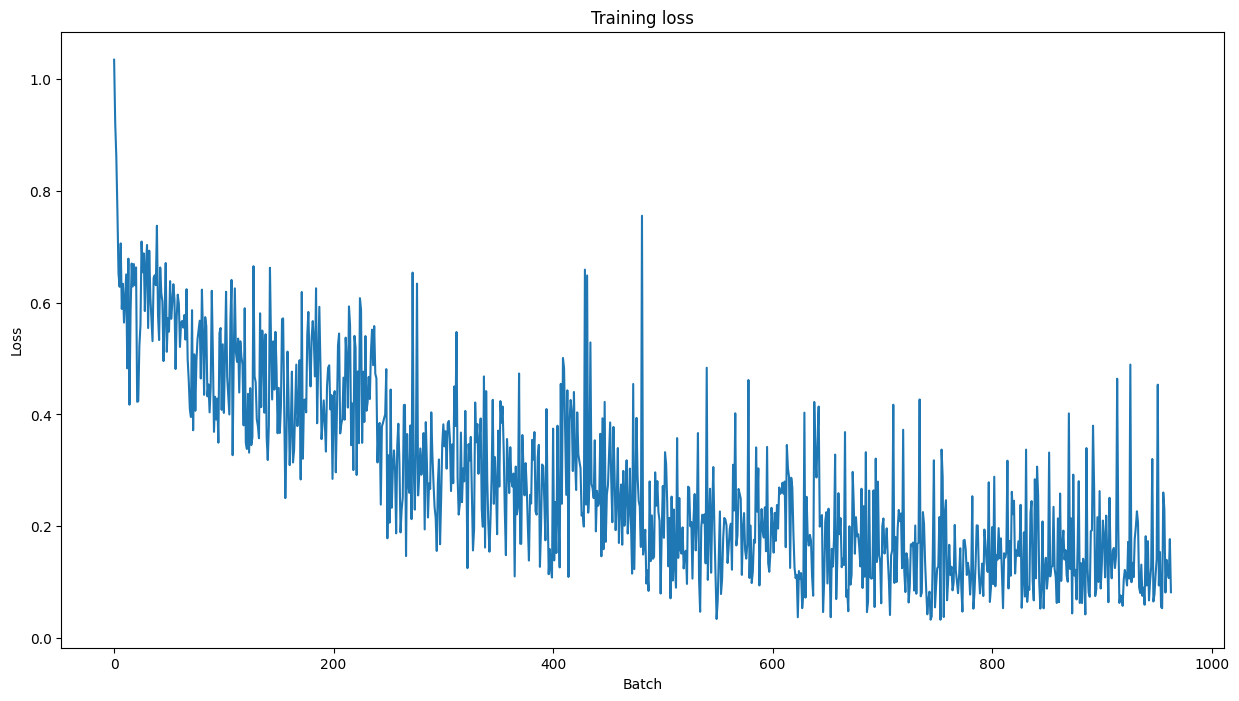

In [22]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Predicting and evaluating using the holdout dataset

In [24]:
df = pd.read_csv("cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

sentences = df.sentence.values

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
     

In [26]:
model.eval()

predictions , true_labels = [], []

 
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    predictions.append(logits)
    true_labels.append(label_ids)

## Evaluating using the Matthews Correlation Coefficient

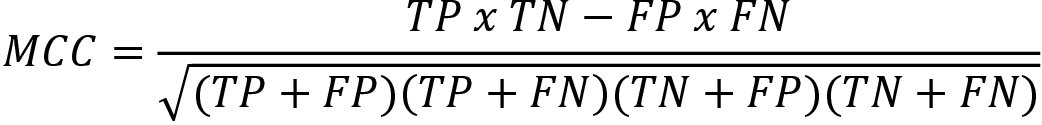

In [30]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)
    
matthews_set


[0.049286405809014416,
 -0.21684543705982773,
 0.4040950971038548,
 0.23372319715296222,
 0.5222329678670935,
 0.6777932975034471,
 0.4879500364742666,
 0.0,
 0.9165151389911681,
 0.8246211251235321,
 0.9229582069908973,
 0.7419408268023742,
 0.8749672939989046,
 0.7141684885491869,
 0.2342878320018382,
 0.6457765999379483,
 0.0]

## Matthews evaluation for the whole dataset

In [31]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5554891378368177